In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np




from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\ganes\AppData\Local\Temp\ipykernel_1788\814062759.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [3]:

# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [4]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [5]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [6]:
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"

In [7]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
#save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [8]:

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [9]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

C:\Users\ganes\AppData\Local\Temp\ipykernel_1788\1118522398.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
features = load(open("features.p","rb"))


In [11]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [12]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [13]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
#dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [14]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [15]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.47340965, 0.01730897, 0.07334232, ..., 0.08557957, 0.02102298,
       0.23765525], dtype=float32)

In [16]:
# Define the model

#1 Photo feature extractor - we extracted features from pretrained model Xception. 
#2 Sequence processor - word embedding layer that handles text, followed by LSTM 
#3 Decoder - Both 1 and 2 model produce fixed length vector. They are merged together and processed by dense layer to make final prediction

In [17]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [18]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [19]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [20]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

C:\Users\ganes\AppData\Local\Temp\ipykernel_1788\4483489.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 1180s 197ms/step - loss: 2.8049


testing





man is sitting on rock overlooking the water


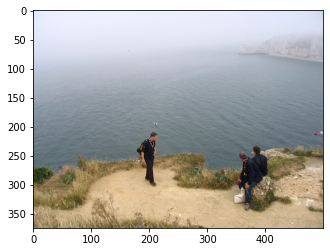

In [40]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import urllib.request

#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
#img_path = args['image']

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    l=in_text.split(" ")
    return " ".join(l[1:-1])
path ='Flicker8k_Dataset/69710415_5c2bfb1058.jpg'
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(path, xception_model)
description = generate_desc(model, tokenizer, photo,32)
img = Image.open(path)
print("\n\n")
print(description)
plt.imshow(img)

In [39]:
import nltk
import nltk.corpus
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(model, descriptions, photos, tokenizer, max_length): 
  actual, predicted= list(), list()

  for key, desc_list in descriptions.items():
    yhat=generate_desc(model, tokenizer, photos [key], max_length) 
    references = [d.split() for d in desc_list]

    actual.append(references)

    predicted.append(yhat.split()) 
    print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

    print('BLEU-2: %f'% corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

    print('BLEU-3: %f' %corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))) 
    print('BLEU-4:%f' %corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

filename= 'Flickr8k_text/Flickr_8k.testImages.txt' 
test =load_photos(filename)

test_descriptions = load_clean_descriptions('descriptions.txt', test)

test_features= load_features(test)

filename='models/model_9.h5'

model= load_model(filename)

evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


BLEU-1: 0.454545
BLEU-2: 0.213201
BLEU-3: 0.000000
BLEU-4:0.000000
BLEU-1: 0.500000
BLEU-2: 0.176777
BLEU-3: 0.000000
BLEU-4:0.000000
BLEU-1: 0.400000
BLEU-2: 0.134840
BLEU-3: 0.000000
BLEU-4:0.000000
BLEU-1: 0.410993
BLEU-2: 0.203389
BLEU-3: 0.144569
BLEU-4:0.000000
BLEU-1: 0.488889
BLEU-2: 0.312694
BLEU-3: 0.171337
BLEU-4:0.000000
BLEU-1: 0.490476
BLEU-2: 0.323411
BLEU-3: 0.205212
BLEU-4:0.000000
BLEU-1: 0.514957
BLEU-2: 0.375985
BLEU-3: 0.297530
BLEU-4:0.192094
BLEU-1: 0.492492
BLEU-2: 0.343233
BLEU-3: 0.270604
BLEU-4:0.170675
BLEU-1: 0.467165
BLEU-2: 0.323443
BLEU-3: 0.250285
BLEU-4:0.155993
BLEU-1: 0.452943
BLEU-2: 0.305976
BLEU-3: 0.236726
BLEU-4:0.146107
BLEU-1: 0.442026
BLEU-2: 0.287793
BLEU-3: 0.221631
BLEU-4:0.134702
BLEU-1: 0.443705
BLEU-2: 0.272717
BLEU-3: 0.207504
BLEU-4:0.123308
BLEU-1: 0.439222
BLEU-2: 0.269881
BLEU-3: 0.202068
BLEU-4:0.118286
BLEU-1: 0.450036
BLEU-2: 0.263654
BLEU-3: 0.191339
BLEU-4:0.108853
BLEU-1: 0.439816
BLEU-2: 0.256185
BLEU-3: 0.182779
BLEU-4:0.10

In [51]:
import numpy as np
import string
from tkinter import *
from tkinter import filedialog
import PIL.Image
import PIL.ImageTk
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from pickle import load
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16
model = load_model("models/model_9.h5")
tokenizer = load(open("tokenizer.p", "rb"))
word_to_index = tokenizer.word_index
index_to_word = dict([index, word] for word, index in word_to_index.items())
vocab_size = len(tokenizer.word_index) + 1
max_len = 32

root = Tk()
root.title("Image Caption Generator")
root.state('zoomed')
root.resizable(width = True, height = True)
root.configure(bg="skyblue")

img1 = PIL.Image.open("logo.png")
img1 = img1.resize((80, 80))
img1 = PIL.ImageTk.PhotoImage(img1)
display_image1 = Label(root, image = img1)
display_image1.image = img1
display_image1.place(relx=0.25,rely=0.04)

panel1 = Label(root, text = 'Department of Information Technology and Computer Applications',fg="darkblue", bg="skyblue",font = ("Arial", 14))
panel1.place(relx = 0.33, rely = 0.05)

panel2 = Label(root, text = 'Andhra University College of Engineering Visakhapatnam',fg="darkblue",bg="skyblue", font = ("Arial", 14))
panel2.place(relx = 0.32, rely = 0.1)

panel3 = Label(root, text = 'Final Year Academic project',fg="red", bg="skyblue",font = ("Arial", 14))
panel3.place(relx = 0.4, rely = 0.15)

panel4 = Label(root, text = 'IMAGE CAPTION GENERATOR',bg="skyblue", font = ("Arial", 18))
panel4.place(relx = 0.37, rely = 0.2)

panel5 = Label(root, text = 'Done By-', fg="darkblue",bg="skyblue",font = ("Arial", 12))
panel5.place(relx = 0.89, rely = 0.78)

panel5 = Label(root, text = 'Ganesh G', bg="skyblue",font = ("Arial", 12))
panel5.place(relx = 0.88, rely = 0.82)

panel6 = Label(root, text = 'Faisal',bg="skyblue", font = ("Arial", 12))
panel6.place(relx = 0.88, rely = 0.86)

panel7 = Label(root, text = 'jagadesh',bg="skyblue", font = ("Arial", 12))
panel7.place(relx = 0.88, rely = 0.9)

panel8 = Label(root, text = 'chetan',bg="skyblue", font = ("Arial", 12))
panel8.place(relx = 0.88, rely = 0.94)

panel9 = Label(root, text = 'Tarun',bg="skyblue", font = ("Arial", 12))
panel9.place(relx = 0.88, rely = 0.97)
filename = None
def chooseImage(event = None):
    global filename
    filename = filedialog.askopenfilename()
    img = PIL.Image.open(filename)
    img = img.resize((350, 300))
    img = PIL.ImageTk.PhotoImage(img)
    display_image = Label(root, image = img)
    display_image.image = img
    display_image.place(relx=0.37,rely=0.27)

value = StringVar()

def generateCaption(event = None):
    if(filename == None):
        value.set("No Image Selected")
    else:
        
        xcepmodel = Xception(include_top=False, pooling="avg")
        img = load_img(filename, target_size = (299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        img = img / 127.5
        img = img - 1.0
        features = xcepmodel.predict(img)

        #vggmodel=VGG16()
        #vggmodel = Model(inputs=model.inputs,outputs=model.layers[-2].output)
        #image = load_img(filename,target_size=(224,224))
        #image = img_to_array(image)
        #image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        
        #image = preprocess_input(image)
        #features = vggmodel.predict(image,verbose=0)
        in_text = 'start'
        for i in range(max_len):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=32)
            pred = model.predict([features,sequence], verbose=0)
            pred = np.argmax(pred)
            word = index_to_word[pred]
            if word is None:
                break
            in_text += ' ' + word
            if word == 'end':
                break
        in_text = ' '.join(in_text.split(" ")[1: -1])
        text = in_text[0].upper() + in_text[1:] + '.'
        value.set(text)
    display_caption = Label(root, textvariable = value,fg='red', bg="skyblue",font=("Arial",18))
    display_caption.place(relx = 0.42, rely = 0.7)

button1 = Button(root, text='Choose an Image', font=(None, 18), activeforeground='red', bd=10, relief=RAISED, height=2, width=15, command = chooseImage) 
button1.place(relx = 0.3, rely = 0.8)
button2 = Button(root, text='Generate Caption', font=(None, 18), activeforeground = 'red', bd=10, relief=RAISED, height=2, width=15, command = generateCaption)
button2.place(relx = 0.56, rely = 0.8)
caption = Label(root, text='Caption : ', bg="skyblue",font=("Arial", 18))
caption.place(relx = 0.35, rely = 0.7)

root.mainloop()
